In [1]:
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
from keras import layers

2024-08-01 20:51:18.010003: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-01 20:51:18.041186: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-01 20:51:18.501698: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#Coletando dados

df = pd.read_excel('/home/andre/Área de Trabalho/Reconstrução da Estatística Pesqueira BR/Rio de Janeiro/Crustaceos/RJ_Reconstrucao_Crustaceos_2024_06_25.xlsx')

df_Camarao_art_e_art_ind = pd.DataFrame(df[['Ano','Camarao_art','Camarao_ind','Camarao_art_ind']])

#Juntando valores de art e ind em art_ind(quando os 2 estão presentes) 
for i in range(len(df_Camarao_art_e_art_ind['Ano'])):
  if pd.isnull(df_Camarao_art_e_art_ind.iloc[i,3])==True and pd.isnull(df_Camarao_art_e_art_ind.iloc[i,2])==False and pd.isnull(df_Camarao_art_e_art_ind.iloc[i,1])==False:
    df_Camarao_art_e_art_ind.iloc[i,3] = df_Camarao_art_e_art_ind.iloc[i,2] + df_Camarao_art_e_art_ind.iloc[i,1] 

dados = df_Camarao_art_e_art_ind[['Ano','Camarao_art','Camarao_art_ind']].dropna().reset_index(drop=True)


anos_com_dados = dados["Ano"].values
anos_para_prever = np.array([1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977])
todos_anos = np.concatenate((anos_para_prever, anos_com_dados))
todos_anos.sort()

#Fazendo as proporções
for i in range(len(dados['Ano'])):
  dados.loc[i,'Prop_Camarao_art'] = dados.loc[i,'Camarao_art'] / dados.loc[i,'Camarao_art_ind']



prop = dados['Prop_Camarao_art'].values
dados.head()

,Ano,Camarao_art,Camarao_art_ind,Prop_Camarao_art
0,1978,22588.0,22822.0,0.989747
1,1979,2625.0,21723.0,0.120840
2,1980,1116.0,1603.0,0.696195
3,1981,651.0,1115.0,0.583857
4,1982,722.0,943.0,0.765642


In [3]:
#Normalização dos dados

ano_mean = np.mean(anos_com_dados)
ano_std = np.std(anos_com_dados)
anos_para_prever_norm = (anos_para_prever - ano_mean)/ano_std
anos_com_dados_norm = (anos_com_dados - ano_mean)/ano_std

prop_mean = np.mean(prop)
prop_std = np.std(prop)
prop_norm = (prop - prop_mean)/prop_std

In [4]:
#Fit do modelo e salvando seus pesos
model = keras.Sequential([layers.Dense(96,activation='leaky_relu',input_shape=(1,)),
                             layers.Dense(32,activation='leaky_relu'),
                             layers.Dense(80,activation='leaky_relu'),
                             layers.Dense(80,activation='leaky_relu'),
                             layers.Dense(96,activation='leaky_relu'),
                             layers.Dense(112,activation='leaky_relu'),
                             layers.Dense(1,activation='linear')])

opt = keras.optimizers.Nadam(learning_rate=0.001)
model.compile(optimizer=opt, loss='mse')


#history = model.fit(anos_com_dados_norm,prop_norm, epochs=500, verbose=1)
#model.save_weights('/home/andre/Área de Trabalho/Reconstrução da Estatística Pesqueira BR/Rio de Janeiro/Crustaceos/Camarao misturado/pesos prop camarao_art/.weights.h5', overwrite=True)

/home/andre/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [5]:
model.load_weights('/home/andre/Área de Trabalho/Reconstrução da Estatística Pesqueira BR/Rio de Janeiro/Crustaceos/Camarao misturado/pesos prop camarao_art/.weights.h5')

/home/andre/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'nadam', because it has 2 variables whereas the saved optimizer has 31 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Previsões dos dados ausentes: [[0.9964244 ]
 [0.98188794]
 [0.96736574]
 [0.9532014 ]
 [0.93901736]
 [0.92404056]
 [0.909616  ]
 [0.8945012 ]
 [0.87856066]
 [0.8609096 ]
 [0.8422048 ]
 [0.8200102 ]
 [0.7966357 ]
 [0.77286094]
 [0.748057  ]
 [0.7167663 ]]


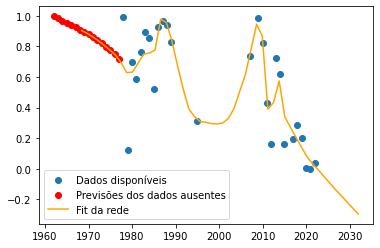

In [6]:
#Previsões
prev_disponiveis = model.predict(anos_com_dados_norm)*prop_std + prop_mean
prev_ausentes = model.predict(anos_para_prever_norm)*prop_std + prop_mean

#Colocando valores negativos para 0
for i in range(len(prev_ausentes)):
    if prev_ausentes[i]<0:
        prev_ausentes[i]=0
    if prev_ausentes[i]>=1:
        prev_ausentes[i]=1

#Plot dos dados e previsões
f1=plt.figure(1).add_subplot()
f1.scatter(anos_com_dados,prop,label='Dados disponíveis')
f1.scatter(anos_para_prever,prev_ausentes, color='red', label='Previsões dos dados ausentes')

#Plot do fit da rede
p = np.linspace(-2,2,50)
y = model.predict(p)*prop_std + prop_mean
f1.plot(p*ano_std + ano_mean,y,color='orange',label='Fit da rede')

#Print das previsões
print('Previsões dos dados ausentes:', prev_ausentes)


plt.legend()
plt.show()

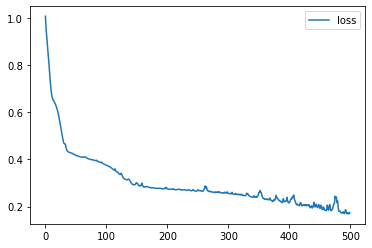

In [10]:
loss = history.history['loss']
plt.plot(loss,label='loss')
plt.legend()
plt.show()

In [10]:
#Lista de anos sem buracos normalizada e sua predição      (para poder me referir por indices)

anos = np.arange(1950,np.max(anos_para_prever)+1)
anos_norm = (anos-ano_mean)/ano_std
prev_continua = model.predict(anos_norm)*prop_std + prop_mean

for i in range(len(prev_continua)):
    if prev_continua[i]<0:
        prev_continua[i]=0
    if prev_continua[i]>=1:
        prev_continua[i]=1

#Trazendo valores previstos para Camarao_art_ind
df_prev_Camarao_art_ind = pd.read_excel('/home/andre/Área de Trabalho/Reconstrução da Estatística Pesqueira BR/Rio de Janeiro/Crustaceos/Desagregações 1950-1974/Desagregações 1950-1974.xlsx')
df_prev_Camarao_art_ind = df_prev_Camarao_art_ind[['Ano','Camarao_art_ind']]



df_preenchido = df[['Ano','Camarao_art']]
for i in range(len(prev_continua)):
      df_preenchido.loc[i,'Camarao_art']=df_prev_Camarao_art_ind.loc[i,'Camarao_art_ind']*prev_continua[i]


with pd.option_context('display.max_rows', None,):
    print(df_preenchido)


#Planilha com os dados preenchidos
df_preenchido.to_excel('/home/andre/Área de Trabalho/Reconstrução da Estatística Pesqueira BR/Rio de Janeiro/Crustaceos/Camarao misturado/Previsão Camarao_art_1962-1977.xlsx')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
     Ano   Camarao_art
0   1950   1455.800415
1   1951   1392.052368
2   1952   1325.763428
3   1953   1196.506470
4   1954   1085.375488
5   1955   1312.276367
6   1956    980.512878
7   1957    741.592285
8   1958    969.680969
9   1959   1555.175903
10  1960    949.994995
11  1961    721.781982
12  1962   1549.439941
13  1963   1568.075073
14  1964   1865.081177
15  1965   2057.715088
16  1966   2129.691406
17  1967   3208.268799
18  1968   5343.994141
19  1969   3368.691650
20  1970   5020.974121
21  1971   4249.449707
22  1972   5174.506348
23  1973   7983.619141
24  1974   1756.786133
25  1975   6325.866699
26  1976   2446.894531
27  1977   5690.407715
28  1978  22588.000000
29  1979   2625.000000
30  1980   1116.000000
31  1981    651.000000
32  1982    722.000000
33  1983    756.000000
34  1984    547.000000
35  1985   1092.000000
36  1986   1248.000000
37  1987   1210.000000
38  1988    841.000000
39  1989    934.000000
40  1990           

In [11]:
#Planilha com as previsões para Camarao_ind  (diferença entre art_ind e art)

Cam_ind_preenchido = df[['Ano','Camarao_ind']]
for i in range(len(df_preenchido['Ano'])):
    if pd.isnull(Cam_ind_preenchido.loc[i,'Camarao_ind'])==True:
        Cam_ind_preenchido.loc[i,'Camarao_ind'] = df_prev_Camarao_art_ind.loc[i,'Camarao_art_ind'] - df_preenchido.loc[i,'Camarao_art']

with pd.option_context('display.max_rows', None,):        
   print(Cam_ind_preenchido)

Cam_ind_preenchido.to_excel('/home/andre/Área de Trabalho/Reconstrução da Estatística Pesqueira BR/Rio de Janeiro/Crustaceos/Camarao misturado/Previsão Camarao_ind.xlsx')

     Ano   Camarao_ind
0   1950      0.000030
1   1951     -0.000050
2   1952     -0.000059
3   1953     -0.000040
4   1954     -0.000051
5   1955     -0.000053
6   1956     -0.000026
7   1957      0.000015
8   1958      0.000020
9   1959      0.000051
10  1960     -0.000011
11  1961      0.000028
12  1962      5.560059
13  1963     28.924927
14  1964     62.918823
15  1965    101.026124
16  1966    138.308594
17  1967    263.731201
18  1968    531.005859
19  1969    397.308350
20  1970    694.025879
21  1971    686.550293
22  1972    969.493652
23  1973   1752.380859
24  1974    448.470535
25  1975   1859.133301
26  1976    824.105469
27  1977   2248.592285
28  1978    234.000000
29  1979  19098.000000
30  1980    487.000000
31  1981    464.000000
32  1982    221.000000
33  1983     90.000000
34  1984     95.000000
35  1985   1004.000000
36  1986    101.000000
37  1987     44.000000
38  1988     55.000000
39  1989    191.000000
40  1990           NaN
41  1991           NaN
42  1992   